## Lab exercise OpenMP

During this exercise we will apply various concpts learned to the stencil code from day 1. If you are stuck at any point, reach out to the organizers. Solutions for various steps are provided so you can advance even if your implementation did not work.

### Goal

The goal of this exercise is to have a parallel version of the diffusion operator.

## Step one: Performance Baseline
In the first step we will see how fast our code performs and what simple pragmas can do

In [ ]:
import timeit
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

We start by timing the base code:

In [78]:
%%bash
module load daint-gpu
module switch PrgEnv-gnu PrgEnv-cray
module load perftools-lite

make VERSION=base

ftn -O3 -hfp3 -eZ -ffree -N255 -ec -eC -eI -eF -rm -h omp -c m_utils.F90
ftn -O3 -hfp3 -eZ -ffree -N255 -ec -eC -eI -eF -rm -h omp -c stencil2d-base.F90
ftn -O3 -hfp3 -eZ -ffree -N255 -ec -eC -eI -eF -rm -h omp m_utils.o stencil2d-base.o -o stencil2d-base.x
cp stencil2d-base.x stencil2d.x


INFO: creating the CrayPat-instrumented executable 'stencil2d-base.x' (lite-samples) ...OK


In [81]:
%%bash --out base_code
srun -n 12 ./stencil2d-base.x+orig --nx 128 --ny 128 --nz 64 --num_iter 1024

In [80]:
print(base_code)
exec(base_code)

# ranks nx ny ny nz num_iter time
data = np.array( [ \
[   12,  128,  128,   64,    1024,  0.2045902E+01], \
] )



If you feel more comfortable with c++, here is the same exeuction:

In [121]:
%%bash
module load daint-gpu

CC stencil2d-base.cpp -fopenmp -o stencil2d-base.out

In [122]:
%%bash --out base_code_cxx
srun -n 1 ./stencil2d-base.out 128 128 64 1024

In [123]:
print(base_code_cxx)
exec(base_code_cxx)

# ranks nx ny ny nz num_iter time
data = np.array( [ \
[ 24, 128, 128, 64, 1024, 9.59362],
] )



Not that you can proceed with either language, the make and run commands are provided for fortran. But this is mostly duplication of what is here

#### Verification
Same as before, we plot the initial and final step to see that the code still produces the same result

In [103]:
def read_field_from_file(filename, num_halo=None):
    (rank, nbits, num_halo, nx, ny, nz) = np.fromfile(filename, dtype=np.int32, count=6)
    offset=(3 + rank) * 32 // nbits
    data = np.fromfile(filename, dtype=np.float32 if nbits == 32 else np.float64, \
                       count=nz * ny * nx + offset)
    if rank == 3:
        return np.reshape(data[offset:], (nz, ny, nx))
    else:
        return np.reshape(data[offset:], (ny, nx))

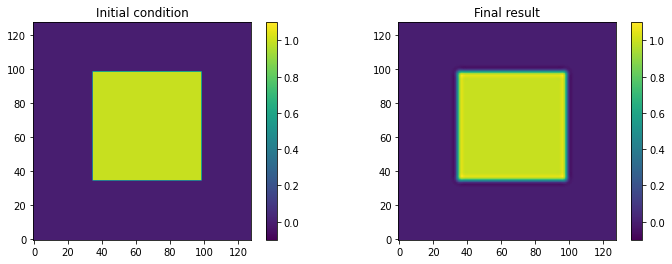

In [104]:
in_field = read_field_from_file('in_field.dat')
out_field = read_field_from_file('out_field.dat')
fig, axs = plt.subplots(1, 2, figsize=(12, 4))
im1 = axs[0].imshow(in_field[0, :, :], origin='lower', vmin=-0.1, vmax=1.1);
fig.colorbar(im1, ax=axs[0]);
axs[0].set_title('Initial condition');
im2 = axs[1].imshow(out_field[0, :, :], origin='lower', vmin=-0.1, vmax=1.1);
fig.colorbar(im2, ax=axs[1]);
axs[1].set_title('Final result');

<div class="alert alert-block alert-info">
<b>Now it's your turn...</b><br>
<b>1.</b> We start by parallelizing various configurations:
    for each of these codes, we measure the performance <br>
<dd>a) only parallelize the i and the j loop<br></dd>
<dd>b) only parallelize the k loop<br></dd>
<dd>c) parallelize both the ij as well as the k loop<br></dd>
</div>

In [66]:
%%bash
# implement a version that parallelizes ij first
module load daint-gpu
module switch PrgEnv-gnu PrgEnv-cray
module load perftools-lite

make VERSION=ijparallel

ftn -O3 -hfp3 -eZ -ffree -N255 -ec -eC -eI -eF -rm -h omp -c m_utils.F90
ftn -O3 -hfp3 -eZ -ffree -N255 -ec -eC -eI -eF -rm -h omp -c stencil2d-ijparallel.F90
ftn -O3 -hfp3 -eZ -ffree -N255 -ec -eC -eI -eF -rm -h omp m_utils.o stencil2d-ijparallel.o -o stencil2d-ijparallel.x
cp stencil2d-ijparallel.x stencil2d.x


INFO: creating the CrayPat-instrumented executable 'stencil2d-ijparallel.x' (lite-samples) ...OK


In [67]:
%%bash --out base_code
srun -n 12 ./stencil2d-ijparallel.x --nx 128 --ny 128 --nz 64 --num_iter 1024

Process is terminated.


In [ ]:
%%bash
# implement a version that parallelizes k first
module load daint-gpu
module switch PrgEnv-gnu PrgEnv-cray
module load perftools-lite
We
make VERSION=kparallel

In [ ]:
%%bash --out kparallel
srun -n 12 ./stencil2d-kparallel.x --nx 128 --ny 128 --nz 64 --num_iter 1024

In [ ]:
%%bash
# implement a version that parallelizes ij and k first
module load daint-gpu
module switch PrgEnv-gnu PrgEnv-cray
module load perftools-lite

make VERSION=ijkparallel

In [ ]:
%%bash --out ijkparallel
srun -n 12 ./stencil2d-ijkparallel.x --nx 128 --ny 128 --nz 64 --num_iter 1024

An analysis of the performance numbers should indicate different speeds.
Can you explain why the fastest version won?

In [ ]:
## remove this once the implementation is done
ijparallel = base_code
kparallel = base_code
ijkparallel = base_code

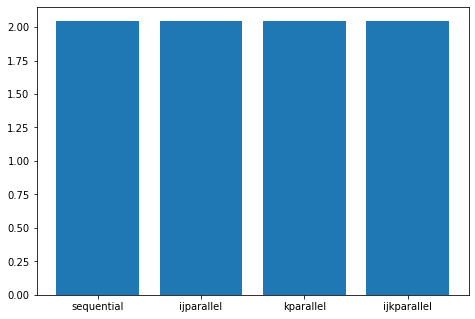

In [68]:
labels = ['sequential', 'ijparallel', 'kparallel', 'ijkparallel']
times = []
# fetch all the times
exec(base_code)
times.append(data[0,5])
exec(ijparallel)
times.append(data[0,5])
exec(kparallel)
times.append(data[0,5])
exec(ijkparallel)
times.append(data[0,5])

# some plotting magic
x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar(labels,times)
plt.show()

### Collapsing loops and fixing the number of threads

OpenMP allows you to parallelize over two loops instead of just one. How does `omp parallel for collapse (2)` compare to these options?

<div class="alert alert-block alert-info">
<b>Now it's your turn...</b><br>
<b>2.</b> We compare collapsing loops to having one or two parallel for loops<br>
<dd>a) only parallelize the j loop<br></dd>
<dd>b) collapse the two<br></dd>
<dd>c) take the ij paralellization from above<br></dd>
</div>

In [ ]:
%%bash
# implement a version that parallelizes j first
module load daint-gpu
module switch PrgEnv-gnu PrgEnv-cray
module load perftools-lite

make VERSION=jparallel

In [ ]:
%%bash --out jparallel
srun -n 12 ./stencil2d-jparallel.x --nx 128 --ny 128 --nz 64 --num_iter 1024

In [ ]:
%%bash
# implement a version that collapses the loops
module load daint-gpu
module switch PrgEnv-gnu PrgEnv-cray
module load perftools-lite

make VERSION=collapse

In [ ]:
%%bash --out collapse
srun -n 12 ./stencil2d-collapse.x --nx 128 --ny 128 --nz 64 --num_iter 1024

In [ ]:
## remove this once the implementation is done
collapse = base_code
jparallel = base_code

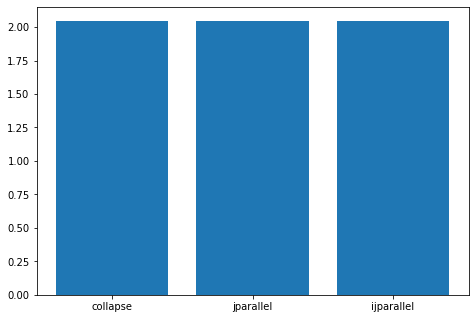

In [69]:
labels = ['collapse', 'jparallel', 'ijparallel']
times = []
# fetch all the times
exec(collapse)
times.append(data[0,5])
exec(jparallel)
times.append(data[0,5])
exec(ijparallel)
times.append(data[0,5])

# some plotting magic
x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar(labels,times)
plt.show()

## Setting the number of threads
We now know that we have 24 threads availiable on each node. We want to investigate what the best number of threads is. It is known that we can oversubscribe the CPU but we will try a couple of variants based on the plain k version

<div class="alert alert-block alert-info">
<b>Now it's your turn...</b><br>
<b>3.</b> We find the optimal number of threads to use with the version that only parallelizes k
</div>

In [ ]:
%%bash
# play with the number of threads
module load daint-gpu
module switch PrgEnv-gnu PrgEnv-cray
module load perftools-lite

make VERSION=nthreads

In [ ]:
%%bash --out nthreads4
srun -n 24 ./stencil2d-nthreads.x --nx 128 --ny 128 --nz 64 --num_iter 1024 --num_threads 4

In [ ]:
%%bash --out nthreads8
srun -n 24 ./stencil2d-nthreads.x --nx 128 --ny 128 --nz 64 --num_iter 1024 --num_threads 8

In [ ]:
%%bash --out nthreads12
srun -n 24 ./stencil2d-nthreads.x --nx 128 --ny 128 --nz 64 --num_iter 1024 --num_threads 12

In [ ]:
%%bash --out nthreads20
srun -n 24 ./stencil2d-nthreads.x --nx 128 --ny 128 --nz 64 --num_iter 1024 --num_threads 20

In [ ]:
%%bash --out nthreads24
srun -n 24 ./stencil2d-nthreads.x --nx 128 --ny 128 --nz 64 --num_iter 1024 --num_threads 24

In [ ]:
%%bash --out nthreads30
srun -n 24 ./stencil2d-nthreads.x --nx 128 --ny 128 --nz 64 --num_iter 1024 --num_threads 30

In [72]:
## remove this once the implementation is done
nthreads4 = base_code
nthreads8 = base_code
nthreads12 = base_code
nthreads20 = base_code
nthreads24 = base_code
nthreads30 = base_code

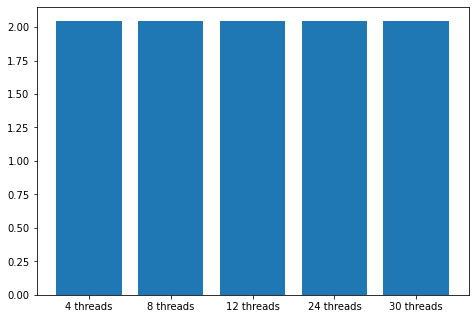

In [74]:
labels = []
times = []
# fetch all the times
exec(nthreads4)
times.append(data[0,5])
labels.append('4 threads')
exec(nthreads8)
times.append(data[0,5])
labels.append('8 threads')
exec(nthreads12)
times.append(data[0,5])
labels.append('12 threads')
exec(nthreads24)
times.append(data[0,5])
labels.append('24 threads')
exec(nthreads30)
times.append(data[0,5])
labels.append('30 threads')

# some plotting magic
x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar(labels,times)
plt.show()

## Scheduling

We use the optimal number of threads `p` moving forward
OpenMP allows for a schedule to be set. Try experimenting what the best schedule is between:
```
static(1)
static(nz/p)
dynamic(1)
dynamic(nz/p)
dynamic(nz/p/2)
guided
```

<div class="alert alert-block alert-info">
<b>Now it's your turn...</b><br>
<b>3.</b> We find the best schedule for our loop, switch between the options above to find the best strategy<br>
   <b>4.</b> Reason why this is the optimal strategy
</div>

## Parallelizing the Halo updated

The halo updates are a set of small loops that are all independent. This leads to using the `nowait` pragma ideally.

<div class="alert alert-block alert-info">
<b>Now it's your turn...</b><br>
<b>5.</b> Implement the parallelization of the halo updates<br>
<b>6.</b> Reason why the performance benefit is what you see
</div>

In [ ]:
%%bash
# play with the number of threads
module load daint-gpu
module switch PrgEnv-gnu PrgEnv-cray
module load perftools-lite

make VERSION=parallelHalo

In [ ]:
%%bash --out parallelHalo
# make sure to set the number of threads to the optimal number
srun -n 12 ./stencil2d-parallelHalo.x --nx 128 --ny 128 --nz 64 --num_iter 1024 --num_threads 24

# Bonus exercises

If you have enough time, there are three additional tasks of higher difficulty to refine some skills

### Manual implementation of the omp parallel for pragma
There is a way to re-implement what a parallel for loop does with the directives `omp parallel`, `omp single`(or similar) and `omp task`. See if you manage to parallelize just the k loop of the code without using `omp parallel for`. What are the performance implications? Why?

### Fusing the computation loops

Currently we have the computation in two ij loops. Ideally we would have the computation in just one loop.

There is a way to fuse the compuatational loops (and have the update on a separate loop). 

What are performance benefits of this?

*cleanup in the end*

In [129]:
%%bash
make clean
rm -rf in_field.dat out_field.dat

rm -f -rf *~ *.o *.mod *.MOD *.i core.* *.out *.lst *.x *.x+orig *.x+[0-9]*
